In [1]:
x = [[5, 7, 8], [6, 3], [3], [1]]

In [5]:
import helpers
xt, xlen = helpers.batch(x)

In [6]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

In [42]:
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [43]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [44]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [45]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

In [46]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [47]:
encoder_inputs_embedded

<tf.Tensor 'embedding_lookup:0' shape=(?, ?, 20) dtype=float32>

In [48]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

In [49]:
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

In [50]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [51]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

In [52]:
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [20]:
decoder_outputs

<tf.Tensor 'plain_decoder/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [21]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

In [22]:
decoder_logits

<tf.Tensor 'fully_connected/Reshape_1:0' shape=(?, ?, 10) dtype=float32>

In [23]:
decoder_prediction = tf.argmax(decoder_logits, 2)

In [24]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

In [25]:
decoder_prediction

<tf.Tensor 'ArgMax:0' shape=(?, ?) dtype=int64>

In [26]:
stepwise_cross_entropy

<tf.Tensor 'Reshape_2:0' shape=(?, ?) dtype=float32>

In [27]:
loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [28]:
sess.run(tf.global_variables_initializer())

In [29]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[8, 9, 2, 8, 6]
[7, 5, 7]
[7, 4, 7, 7, 4, 5, 3, 6]
[9, 3, 8]
[5, 3, 3, 2, 3, 6, 9, 9]
[4, 9, 4, 7, 4, 9, 9, 4]
[3, 6, 8, 7, 9]
[4, 2, 6, 3]
[2, 7, 8, 6, 9, 9]
[7, 4, 5, 6, 9, 6, 2]


In [30]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [31]:
loss_track = []

In [32]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.3476600647
  sample 1:
    input     > [4 4 7 4 6 0 0 0]
    predicted > [6 6 6 6 6 5 6 6 6]
  sample 2:
    input     > [4 2 5 0 0 0 0 0]
    predicted > [6 6 5 5 6 6 1 1 1]
  sample 3:
    input     > [4 8 9 5 6 6 7 9]
    predicted > [7 5 8 8 5 7 7 7 7]
()
batch 1000
  minibatch loss: 0.352187782526
  sample 1:
    input     > [5 3 4 6 8 4 5 9]
    predicted > [3 3 4 6 8 9 5 9 1]
  sample 2:
    input     > [8 8 8 0 0 0 0 0]
    predicted > [8 8 8 1 0 0 0 0 0]
  sample 3:
    input     > [9 5 5 9 3 4 3 0]
    predicted > [9 5 3 3 3 3 3 1 0]
()
batch 2000
  minibatch loss: 0.148123592138
  sample 1:
    input     > [2 9 2 2 4 2 0 0]
    predicted > [2 9 2 2 4 2 1 0 0]
  sample 2:
    input     > [8 5 5 5 9 0 0 0]
    predicted > [5 5 5 5 9 1 0 0 0]
  sample 3:
    input     > [3 2 7 9 9 8 6 0]
    predicted > [3 2 7 9 9 6 6 1 0]
()
batch 3000
  minibatch loss: 0.128407254815
  sample 1:
    input     > [4 6 6 8 9 0 0 0]
    predicted > [4 6 6 8 9 1 0 0 0]


In [38]:
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

loss 0.1412 after 300100 examples (batch_size=100)


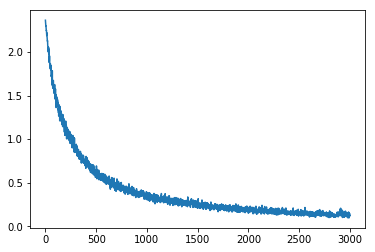

In [39]:
plt.show()